# Tutorial 9: Curl and CrypTen approximations

In this tutorial, we explore the accuracy of Curl and CrypTen. All configuration parameters are defined in the [default config](../configs/default.yaml) file. We can use these configuration parameters to choose between Curl and CrypTen. 

> **Note:** make sure to set the ```mpc.provider``` to ```TFP```, otherwise ```curl.init()``` gets stuck in the notebook.

The parameters include:
- ```encoder.trunc_method```: Probabilistic truncation method used. The truncation method is applied either after a multiplication (```encoder.trunc_method.prod```) or within Curl's secure DWT-compressed LUT protocol (```encoder.trunc_method.lut```). Possible truncation protocols:
  - ```crypten```: CrypTen original truncation.
  - ```egk```: Escudero et al. [EGK+20, §5.1] probabilistic truncation in a ring.

- ```functions.<function>_method```: method used for each function ```<function>```. Each function has its own methods for CrypTen approximations. However, Curl allows two main methods:
  - ```haar```: it uses the Haar approach described in Curl's paper Section IV.B.
  - ```bior```: it uses the Biorthogonal approach described in Curl's paper Section IV.B. 
  > **Note I:** for s-shaped functions (sigmoid, tahn, erf), trigonometric (sin, cos), GeLU and SiLU, the ```haar``` and ```bior``` methods are used within the protocols described in the paper for each function. In case you want to test an approximation only using the DWT-compressed LUT protocol use the flags ```haar-lut-only``` and ```bior-lut-only``` instead. 
  
  > **Note II:** (only) the ```inv_sqrt``` function supports an additional flag method (```tailored_haar```) which allows to use a 2 LUT approximation approach to improve accuracy. ```tailored_bior``` is currently not supported.

- ```functions.<function>_max_bits```: maximum integer number to include in the table. E.g., ```sqrt_lut_max_bits: 8``` generates a LUT for the range ```(0, 2**8] = (0, 256]```.

- ```functions.<function>_haar_size_bits```: determines the size of the compressed LUT with the Haar method (the same applies using ```Bior``` for Biorthogonal method). E.g., ```sqrt_haar_size_bits: 7``` generates a LUT of size ```2**7 = 128```.

In [1]:
import curl
import torch
from curl.config import cfg
import timeit
import curl.communicator as comm
import logging
import matplotlib.pyplot as plt
import numpy as np

curl.init()

[Device] LUTs initialized for cpu



In [2]:
# General parameters
num_iters = 1
print_terms = 1

def print_errors(x, z_enc, plot_error = False, title = None):
    """Computes the following metrics to compare between the
    true value and the approximation value:
    
    - TAE (Total Absolute Error): The sum of the absolute errors.
    - MAE (Mean Absolute Error): The mean of the absolute errors.
    - MRE (Mean Relative Error): The mean of the relative errors, where relative error is defined as the absolute difference 
      between true and approximated values divided by the true values.
    - MAX (Maximum Error): The maximum absolute error.
    - ARGMAX (Argument with Maximum Error): The index of the element with the maximum absolute error.
 
    If `plot` is True, it also plots the absolute errors.

    Parameters:
        x (torch.Tensor): The true values.
        z_enc (curl.CrypTensor): The encoded approximation values.
        plot (bool, optional): If True, plots the absolute errors. Default is False.
    """
    
    diff = torch.abs(x - z_enc.get_plain_text()).numpy()
    relative = torch.abs((z_enc.get_plain_text()-x)/x)
    relative = relative[relative != float("inf")].numpy()
    relative = relative[~np.isnan(relative)]
    curl.print(f"TAE: {diff.sum():e}, MAE: {diff.mean():e}, MRE: {relative.mean():e}, MAX: {diff.max():e}, ARGMAX: {diff.argmax()}")
    if plot_error:
        plt.plot(diff, label=title+' Absolute Error')
        plt.legend()
        plt.xlabel('Index')
        plt.ylabel('Error')
        plt.title('Absolute Errors')
    

def print_app(name, end_time, start_time):
    curl.print(f"  {name}: {num_iters} iterations in {end_time - start_time} sec.") # : {z_enc.get_plain_text()[:print_terms]}")


## Compare truncation protocols

In this section, we start by comparing crypten and EGK probabilistic truncation methods.

In [4]:
import torch
import curl.mpc as mpc


threshold_error = 2**20 # diff amount to be considered as a big error
samples = 2**25         # nr of samples


@mpc.run_multiprocess(world_size=2)
def test_correctness_error():
    
    # generate a tensor of size 'samples' with all elements equal 128
    tensor = torch.rand(samples) * 128
    result = tensor.clone()
    result = tensor * tensor
    a_enc = curl.cryptensor(tensor)

    with cfg.temp_override({"encoder.trunc_method.prod": 'crypten'}):
        curl.print("==== CrypTen ====")
        num_errors = 0
        a_sq_enc = a_enc * a_enc # multiply and truncate
        a_sq = a_sq_enc.get_plain_text()
        
        abs_diff = torch.abs(a_sq - result)
        # Check which elements are greater than or equal to 'threshold_error'
        errors = abs_diff >= threshold_error
        # Count the number of such elements
        num_errors = torch.sum(errors).item()
        curl.print("Total number of tests:", samples)
        curl.print("Total number of correctness errors:", num_errors)
        curl.print("\n")
    
    with cfg.temp_override({"encoder.trunc_method.prod": 'egk'}):
        curl.print("====   EGK   ====")
        num_errors = 0
        a_sq_enc = a_enc * a_enc # multiply and truncate
        a_sq = a_sq_enc.get_plain_text()
        
        abs_diff = torch.abs(a_sq - result)
        # Check which elements are greater than or equal to 'threshold_error'
        errors = abs_diff >= threshold_error
        # Count the number of such elements
        num_errors = torch.sum(errors).item()
        curl.print("Total number of tests:", samples)
        curl.print("Total number of correctness errors:", num_errors)
           

test_correctness_error()

==== CrypTen ====
Total number of tests: 33554432
Total number of correctness errors: 54


====   EGK   ====
Total number of tests: 33554432
Total number of correctness errors: 0


[None, None]

# Functions

We compare a print the approximation errors for Curl and CrypTen. For every function we present two scripts:
1. Run only with one party: Plain operations are executed so probabilistic truncation and division protocols are not used. This leads to improved accuracy.
2. Run multiparty protocols. This leads to true approximation values.

## Reciprocal


Reciprocal:
  Approx: 1 iterations in 0.08656962399982149 sec.
TAE: 1.522708e-01, MAE: 2.436332e-04, MRE: 1.039119e-02, MAX: 9.363797e-04, ARGMAX: 612
  Log: 1 iterations in 0.12428026899988254 sec.
TAE: 6.001518e-02, MAE: 9.602428e-05, MRE: 1.415940e-03, MAX: 2.909720e-03, ARGMAX: 3
  Haar: 1 iterations in 0.013118011999722512 sec.
TAE: 1.533943e+00, MAE: 2.454308e-03, MRE: 9.578226e-03, MAX: 1.798123e-01, ARGMAX: 1
  Bior: 1 iterations in 0.0140270239999154 sec.
TAE: 5.335472e-01, MAE: 8.536755e-04, MRE: 1.705819e-03, MAX: 1.298856e-01, ARGMAX: 1


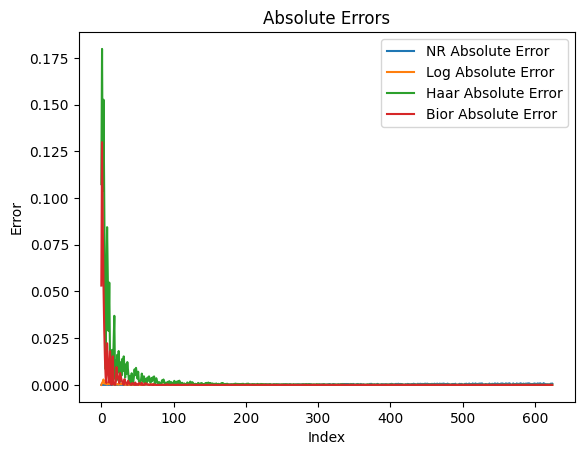

In [3]:
# 1 party protocol to visualize graphs

x = torch.arange(start=1, end=63.5, step=0.1)
x_enc = curl.cryptensor(x)

print("\nReciprocal:")
with cfg.temp_override({"functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.reciprocal()  # Private
    print_app("Approx", timeit.default_timer(), start1)
    print_errors(x.reciprocal(), z_enc, plot_error=True, title='NR')
with cfg.temp_override({"functions.reciprocal_method": 'log', "functions.log_method": 'iter'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.reciprocal()  # Private
    print_app("Log", timeit.default_timer(), start1)
    print_errors(x.reciprocal(), z_enc, plot_error=True, title='Log')
with cfg.temp_override({"functions.reciprocal_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.reciprocal()  # Private
    print_app("Haar", timeit.default_timer(), start1)
    print_errors(x.reciprocal(), z_enc, plot_error=True, title='Haar')
with cfg.temp_override({"functions.reciprocal_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.reciprocal()  # Private
    print_app("Bior", timeit.default_timer(), start1)
    print_errors(x.reciprocal(), z_enc, plot_error=True, title='Bior')

In [4]:
# multiparty script to check accuracy

import curl.mpc as mpc

@mpc.run_multiprocess(world_size=2)    
def test_rec():
    #Construct example input CrypTensor
    x = torch.arange(start=1, end=63.5, step=0.1)
    x_enc = curl.cryptensor(x)

    curl.print("\nReciprocal:")
    with cfg.temp_override({"functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        print_app("Approx", timeit.default_timer(), start1)
        print_errors(x.reciprocal(), z_enc, plot_error=True, title='NR')
    with cfg.temp_override({"functions.reciprocal_method": 'log', "functions.log_method": 'iter'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        print_app("Log", timeit.default_timer(), start1)
        print_errors(x.reciprocal(), z_enc, plot_error=True, title='Log')
    with cfg.temp_override({"functions.reciprocal_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        print_app("Haar", timeit.default_timer(), start1)
        print_errors(x.reciprocal(), z_enc, plot_error=True, title='Haar')
    with cfg.temp_override({"functions.reciprocal_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        print_app("Bior", timeit.default_timer(), start1)
        print_errors(x.reciprocal(), z_enc, plot_error=True, title='Bior')

test_rec()


Reciprocal:
  Approx: 1 iterations in 0.11110099200004697 sec.
TAE: 1.080850e-01, MAE: 1.729360e-04, MRE: 7.359003e-03, MAX: 8.785408e-04, ARGMAX: 615
  Log: 1 iterations in 0.20962785400024586 sec.
TAE: 7.719491e-02, MAE: 1.235119e-04, MRE: 2.067411e-03, MAX: 2.400696e-03, ARGMAX: 5
  Haar: 1 iterations in 0.17138197699978264 sec.
TAE: 1.434843e+00, MAE: 2.295749e-03, MRE: 9.596231e-03, MAX: 1.798123e-01, ARGMAX: 1
  Bior: 1 iterations in 0.10857807899992622 sec.
TAE: 3.625417e-01, MAE: 5.800667e-04, MRE: 1.261793e-03, MAX: 8.577472e-02, ARGMAX: 2


[None, None]

## Logarithm


Logarithm:
  Approx: 1 iterations in 0.09546358399984456 sec.: tensor([0.0003])
TAE: 1.373820e+01, MAE: 2.198112e-02, MRE: 6.453529e-03, MAX: 3.598404e-02, ARGMAX: 624
  Haar  : 1 iterations in 0.010677916999611625 sec.: tensor([0.1157])
TAE: 5.428663e+00, MAE: 8.685861e-03, MRE: 7.473760e-03, MAX: 1.480401e-01, ARGMAX: 4
  Bior  : 1 iterations in 0.014151243000014802 sec.: tensor([0.0240])
TAE: 4.232607e-01, MAE: 6.772171e-04, MRE: 1.451967e-03, MAX: 6.314655e-02, ARGMAX: 2


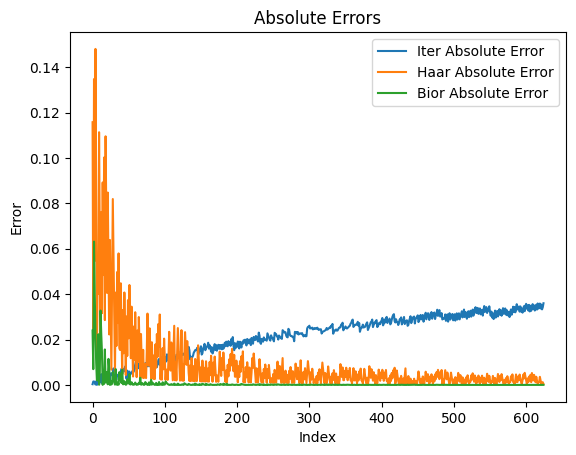

In [4]:
# 1 party protocol to visualize graphs

x = torch.arange(1, 63.5, 0.1)
x_enc = curl.cryptensor(x)

print("\nLogarithm:")
with cfg.temp_override({"functions.log_method": 'iter'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.log()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.log(), z_enc, plot_error=True, title='Iter')
with cfg.temp_override({"functions.log_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.log()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.log(), z_enc, plot_error=True, title='Haar')
with cfg.temp_override({"functions.log_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.log()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.log(), z_enc, plot_error=True, title='Bior')

In [5]:
# multiparty script to check accuracy

import curl.mpc as mpc

@mpc.run_multiprocess(world_size=2)
def test_log():
    x = torch.arange(0.1, 63.5, 0.1)
    x_enc = curl.cryptensor(x)
    curl.print("\nLogarithm:")
    with cfg.temp_override({"functions.log_method": 'iter'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.log()  # Private
        curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.log(), z_enc, plot_error=True, title='Iter')
    with cfg.temp_override({"functions.log_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.log()  # Private
        curl.print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.log(), z_enc, plot_error=True, title='Haar')
    with cfg.temp_override({"functions.log_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.log()  # Private
        curl.print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.log(), z_enc, plot_error=True, title='Bior')

test_log()


Logarithm:
  Approx: 1 iterations in 0.19042025699991427 sec.: tensor([-2.3127])
TAE: 1.352624e+01, MAE: 2.133476e-02, MRE: 6.351868e-03, MAX: 3.712559e-02, ARGMAX: 625
  Haar  : 1 iterations in 0.13195750699969722 sec.: tensor([-1.0000])
TAE: 9.702722e+00, MAE: 1.530398e-02, MRE: 2.098839e-02, MAX: 1.302616e+00, ARGMAX: 0
  Bior  : 1 iterations in 0.32627097299973684 sec.: tensor([-6.2035])
TAE: 1.196348e+01, MAE: 1.886985e-02, MRE: 2.115923e-02, MAX: 3.900952e+00, ARGMAX: 0


[None, None]

## Square root


Square Root:
  Approx: 1 iterations in 0.06225888599965401 sec.: tensor([0.3147])
TAE: 1.498132e+04, MAE: 5.900482e+00, MRE: 3.926680e-01, MAX: 3.188100e+01, ARGMAX: 2536
  Haar   : 1 iterations in 0.018231846000162477 sec.: tensor([0.9428])
TAE: 1.631468e+02, MAE: 6.425633e-02, MRE: 1.429860e-02, MAX: 8.871864e-01, ARGMAX: 6
  Bior   : 1 iterations in 0.02464501999975255 sec.: tensor([0.2285])
TAE: 5.742686e+00, MAE: 2.261791e-03, MRE: 2.001815e-03, MAX: 3.332466e-01, ARGMAX: 6


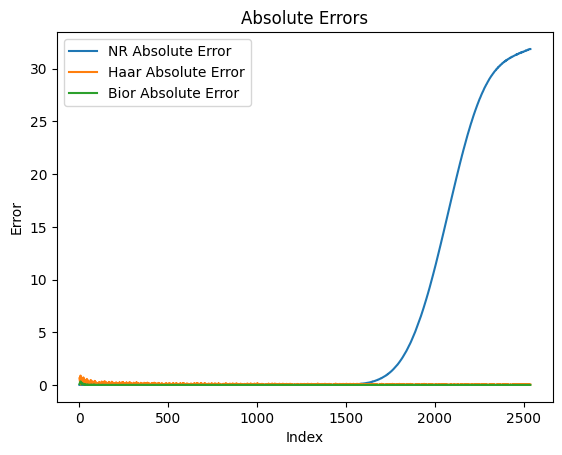

In [8]:
# 1 party protocol to visualize graphs

x = torch.arange(start=0.1, end=254, step=0.1)
x_enc = curl.cryptensor(x)

print("\nSquare Root:")
with cfg.temp_override({"functions.sqrt_method": 'NR', "functions.inv_sqrt_method": 'NR'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sqrt()  # Private
    curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.sqrt(), z_enc, plot_error=True, title='NR')
with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sqrt()  # Private
    curl.print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.sqrt(), z_enc, plot_error=True, title='Haar')
with cfg.temp_override({"functions.sqrt_method": 'bior', "functions.inv_sqrt_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sqrt()  # Private
    curl.print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.sqrt(), z_enc, plot_error=True, title='Bior')

In [6]:
# multiparty script to check accuracy

import curl.mpc as mpc

@mpc.run_multiprocess(world_size=2)
def test_sqrt():
    x = torch.arange(start=0.1, end=256, step=0.1)
    x_enc = curl.cryptensor(x)
    curl.print("\nSquare Root:")
    with cfg.temp_override({"functions.sqrt_method": 'NR', "functions.inv_sqrt_method": 'NR'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sqrt()  # Private
        curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.sqrt(), z_enc, plot_error=True, title='NR')
    with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sqrt()  # Private
        curl.print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.sqrt(), z_enc, plot_error=True, title='Haar')
    with cfg.temp_override({"functions.sqrt_method": 'bior', "functions.inv_sqrt_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sqrt()  # Private
        curl.print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.sqrt(), z_enc, plot_error=True, title='Bior')

test_sqrt()


Square Root:
  Approx: 1 iterations in 0.07127174300057959 sec.: tensor([0.3147])
TAE: 1.562070e+04, MAE: 6.104218e+00, MRE: 4.052638e-01, MAX: 3.200624e+01, ARGMAX: 2558
  Haar   : 1 iterations in 0.27355439199982357 sec.: tensor([0.9428])
TAE: 2.852562e+02, MAE: 1.114717e-01, MRE: 1.754006e-02, MAX: 1.505406e+01, ARGMAX: 2558
  Bior   : 1 iterations in 0.3750911149991225 sec.: tensor([0.2285])
TAE: 1.361220e+02, MAE: 5.319345e-02, MRE: 5.454978e-03, MAX: 1.660484e+01, ARGMAX: 2547


[None, None]

## Inv sqrt


Inverse Square Root:
  Approx: 1 iterations in 0.08791699299990796 sec.: tensor([1.4142])
TAE: 6.776926e+01, MAE: 2.662839e-02, MRE: 3.996014e-01, MAX: 1.282157e-01, ARGMAX: 2390
  Tailored Haar   : 1 iterations in 0.12396044900015113 sec.: tensor([1.4114])
TAE: 2.463244e+00, MAE: 9.678758e-04, MRE: 2.924394e-03, MAX: 1.550126e-01, ARGMAX: 7
  Haar   : 1 iterations in 0.23482414799991602 sec.: tensor([1.3354])
TAE: 9.770331e-01, MAE: 3.839030e-04, MRE: 9.046165e-04, MAX: 8.501434e-02, ARGMAX: 2
  Bior   : 1 iterations in 0.2690152070003933 sec.: tensor([1.4083])
TAE: 4.943475e-02, MAE: 1.942426e-05, MRE: 7.026597e-05, MAX: 8.628845e-03, ARGMAX: 2


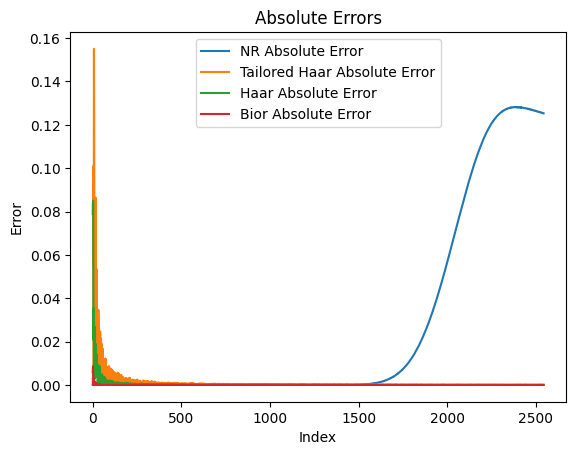

In [14]:
# 1 party protocol to visualize graphs

x = torch.arange(start=0.5, end=255, step=0.1)
x_enc = curl.cryptensor(x)

curl.print("\nInverse Square Root:")
with cfg.temp_override({"functions.sqrt_method": 'NR', "functions.inv_sqrt_method": 'NR'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.inv_sqrt()  # Private
    curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.sqrt().reciprocal(), z_enc, plot_error=True, title='NR')
with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'tailored_haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.inv_sqrt()  # Private
    curl.print("  Tailored Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.sqrt().reciprocal(), z_enc, plot_error=True, title='Tailored Haar')
with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.inv_sqrt()  # Private
    curl.print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.sqrt().reciprocal(), z_enc, plot_error=True, title='Haar')
with cfg.temp_override({"functions.sqrt_method": 'bior', "functions.inv_sqrt_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.inv_sqrt()  # Private
    curl.print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.sqrt().reciprocal(), z_enc, plot_error=True, title='Bior')

In [7]:
# multiparty script to check accuracy

import curl.mpc as mpc

@mpc.run_multiprocess(world_size=2)
def test_inv_sqrt():
    x = torch.arange(0.1, 256, 0.1)
    x_enc = curl.cryptensor(x)

    curl.print("\nInverse Square Root:")
    with cfg.temp_override({"functions.sqrt_method": 'NR', "functions.inv_sqrt_method": 'NR'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.inv_sqrt()  # Private
        curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.sqrt().reciprocal(), z_enc, plot_error=True, title='NR')
    with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'tailored_haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.inv_sqrt()  # Private
        curl.print("  Tailored Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.sqrt().reciprocal(), z_enc, plot_error=True, title='Tailored Haar')
    with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.inv_sqrt()  # Private
        curl.print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.sqrt().reciprocal(), z_enc, plot_error=True, title='Haar')
    with cfg.temp_override({"functions.sqrt_method": 'bior', "functions.inv_sqrt_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.inv_sqrt()  # Private
        curl.print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.sqrt().reciprocal(), z_enc, plot_error=True, title='Bior')

test_inv_sqrt()


Inverse Square Root:
  Approx: 1 iterations in 0.07074647500030551 sec.: tensor([3.1469])
TAE: 6.904339e+01, MAE: 2.698061e-02, MRE: 4.052605e-01, MAX: 1.281771e-01, ARGMAX: 2398
  Tailored Haar   : 1 iterations in 0.4008239830000093 sec.: tensor([3.1685])
TAE: 1.047235e+01, MAE: 4.092359e-03, MRE: 5.446441e-02, MAX: 2.754520e+00, ARGMAX: 2558
  Haar   : 1 iterations in 0.44387906300016766 sec.: tensor([2.3431])
TAE: 2.236689e+00, MAE: 8.740479e-04, MRE: 1.071699e-03, MAX: 8.191838e-01, ARGMAX: 0
  Bior   : 1 iterations in 0.5294759439993868 sec.: tensor([12.1991])
TAE: 1.775062e+01, MAE: 6.936546e-03, MRE: 2.701157e-03, MAX: 9.036774e+00, ARGMAX: 0


[None, None]

## Sin


Sin:
  Approx: 1 iterations in 0.07788606099984463 sec.: tensor([-6.4807])
TAE: 1.097639e+03, MAE: 8.575308e-01, MRE: 1.624391e+00, MAX: 5.560657e+00, ARGMAX: 0
  Haar  : 1 iterations in 0.02272945099957724 sec.: tensor([-0.8805])
TAE: 8.593576e+01, MAE: 6.713732e-02, MRE: 2.152852e+10, MAX: 2.633354e-01, ARGMAX: 862
  Bior  : 1 iterations in 0.032956086000012874 sec.: tensor([-0.9234])
TAE: 5.927139e+00, MAE: 4.630578e-03, MRE: 5.368709e+07, MAX: 3.708524e-02, ARGMAX: 151


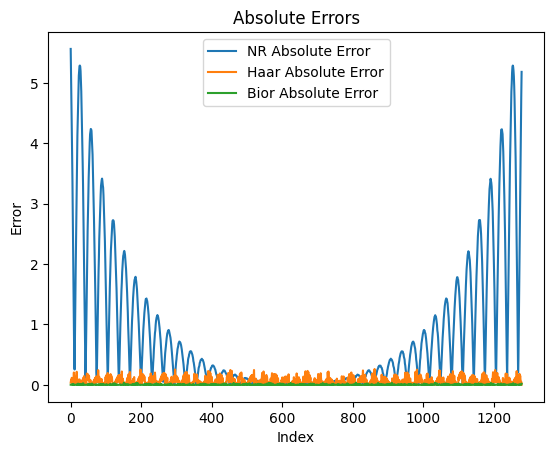

In [15]:
# 1 party protocol to visualize graphs

x = torch.arange(start=-64, end=64, step=0.1)
x_enc = curl.cryptensor(x)

curl.print("\nSin:")
with cfg.temp_override({"functions.trigonometry_method": 'NR'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sin()  # Private
    curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.sin(), z_enc, plot_error=True, title='NR')
with cfg.temp_override({"functions.trigonometry_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sin()  # Private
    curl.print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.sin(), z_enc, plot_error=True, title='Haar')
with cfg.temp_override({"functions.trigonometry_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sin()  # Private
    curl.print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.sin(), z_enc, plot_error=True, title='Bior')

In [8]:
# multiparty script to check accuracy

import curl.mpc as mpc

@mpc.run_multiprocess(world_size=2)
def test_sin():
    x = torch.arange(-64, 64, 0.1)
    x_enc = curl.cryptensor(x)

    curl.print("\nSin:")
    with cfg.temp_override({"functions.trigonometry_method": 'NR'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sin()  # Private
        curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.sin(), z_enc, plot_error=True, title='NR')
    with cfg.temp_override({"functions.trigonometry_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sin()  # Private
        curl.print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.sin(), z_enc, plot_error=True, title='Haar')
    with cfg.temp_override({"functions.trigonometry_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sin()  # Private
        curl.print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.sin(), z_enc, plot_error=True, title='Bior')

test_sin()


Sin:
  Approx: 1 iterations in 0.06993813600001886 sec.: tensor([-6.5193])
TAE: 1.089787e+03, MAE: 8.513959e-01, MRE: 1.523711e+00, MAX: 5.599322e+00, ARGMAX: 0
  Haar  : 1 iterations in 0.3184972299995934 sec.: tensor([-0.9554])
TAE: 8.799876e+01, MAE: 6.874903e-02, MRE: 2.152852e+10, MAX: 2.810046e-01, ARGMAX: 860
  Bior  : 1 iterations in 0.7197408860001815 sec.: tensor([-0.9234])
TAE: 5.964852e+00, MAE: 4.660041e-03, MRE: 5.368709e+07, MAX: 3.524452e-02, ARGMAX: 467


[None, None]

## Cos


Cos:
  Approx: 1 iterations in 0.0612674980002339 sec.: tensor([3.4309])
TAE: 1.141995e+03, MAE: 8.921834e-01, MRE: 1.495499e+00, MAX: 5.899262e+00, ARGMAX: 9
  Haar  : 1 iterations in 0.02207946299949981 sec.: tensor([0.2898])
TAE: 8.708102e+01, MAE: 6.803205e-02, MRE: 4.292395e-01, MAX: 2.678676e-01, ARGMAX: 654
  Bior  : 1 iterations in 0.03293771500011644 sec.: tensor([0.3954])
TAE: 5.988783e+00, MAE: 4.678736e-03, MRE: 9.663038e-03, MAX: 3.609055e-02, ARGMAX: 1239


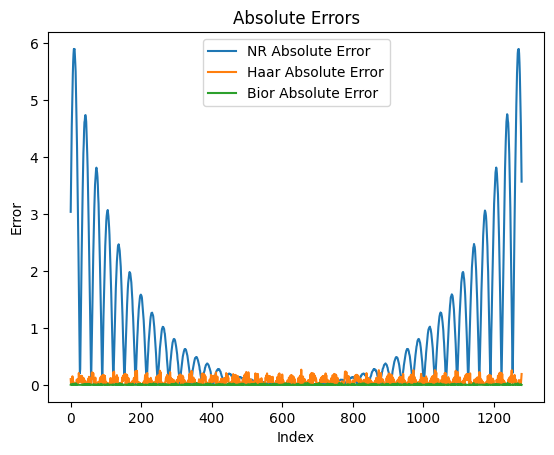

In [10]:
# 1 party protocol to visualize graphs

x = torch.arange(start=-64, end=64, step=0.1)
x_enc = curl.cryptensor(x)

curl.print("\nCos:")
with cfg.temp_override({"functions.trigonometry_method": 'NR'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.cos()  # Private
    curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.cos(), z_enc, plot_error=True, title='NR')
with cfg.temp_override({"functions.trigonometry_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.cos()  # Private
    curl.print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.cos(), z_enc, plot_error=True, title='Haar')
with cfg.temp_override({"functions.trigonometry_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.cos()  # Private
    curl.print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.cos(), z_enc, plot_error=True, title='Bior')

In [3]:
# multiparty script to check accuracy

import curl.mpc as mpc

@mpc.run_multiprocess(world_size=2)
def test_cos():
    x = torch.arange(-64, 64, 0.1)
    x_enc = curl.cryptensor(x)

    curl.print("\nCos:")
    with cfg.temp_override({"functions.trigonometry_method": 'NR'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.cos()  # Private
        curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.cos(), z_enc, plot_error=True, title='NR')
    with cfg.temp_override({"functions.trigonometry_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.cos()  # Private
        curl.print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.cos(), z_enc, plot_error=True, title='Haar')
    with cfg.temp_override({"functions.trigonometry_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.cos()  # Private
        curl.print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.cos(), z_enc, plot_error=True, title='Bior')

test_cos()


Cos:
  Approx: 1 iterations in 0.07884803199976886 sec.: tensor([3.4355])
TAE: 1.133879e+03, MAE: 8.858431e-01, MRE: 1.443236e+00, MAX: 5.935490e+00, ARGMAX: 1270
  Haar  : 1 iterations in 0.3163323649996528 sec.: tensor([0.2898])
TAE: 8.493337e+01, MAE: 6.635420e-02, MRE: 4.112874e-01, MAX: 2.719598e-01, ARGMAX: 809
  Bior  : 1 iterations in 0.720542196999304 sec.: tensor([0.3954])
TAE: 5.963447e+00, MAE: 4.658943e-03, MRE: 9.699911e-03, MAX: 3.657943e-02, ARGMAX: 200


[None, None]

## Sigmoid


Sigmoid:
  Approx: 1 iterations in 0.042788878999999724 sec.: tensor([1.5259e-05])
TAE: 9.050853e-02, MAE: 7.070979e-05, MRE: 7.810717e+20, MAX: 1.953125e-03, ARGMAX: 640
  Haar  : 1 iterations in 0.02340162300015436 sec.: tensor([0.])
TAE: 1.404780e+00, MAE: 1.097485e-03, MRE: 7.271309e-01, MAX: 6.756535e-02, ARGMAX: 639
  Bior  : 1 iterations in 0.03455981399974917 sec.: tensor([0.])
TAE: 2.166244e-01, MAE: 1.692378e-04, MRE: 4.316038e-01, MAX: 1.273572e-02, ARGMAX: 647


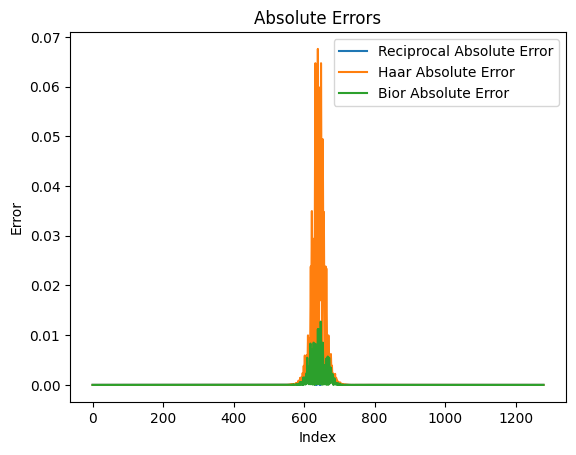

In [17]:
# 1 party protocol to visualize graphs

x = torch.arange(-64, 64, 0.1)
x_enc = curl.cryptensor(x)

curl.print("\nSigmoid:")
with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sigmoid()  # Private
    curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.sigmoid(), z_enc, plot_error=True, title='Reciprocal')
with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sigmoid()  # Private
    curl.print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.sigmoid(), z_enc, plot_error=True, title='Haar')
with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sigmoid()  # Private
    curl.print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.sigmoid(), z_enc, plot_error=True, title='Bior')

In [4]:
# multiparty script to check accuracy

import curl.mpc as mpc

@mpc.run_multiprocess(world_size=2)    
def test_sig():
    x = torch.arange(-64, 64, 0.1)
    x_enc = curl.cryptensor(x)

    curl.print("\nSigmoid:")
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sigmoid()  # Private
        curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.sigmoid(), z_enc, plot_error=True, title='Reciprocal')
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sigmoid()  # Private
        curl.print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.sigmoid(), z_enc, plot_error=True, title='Haar')
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sigmoid()  # Private
        curl.print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.sigmoid(), z_enc, plot_error=True, title='Bior')

test_sig()


Sigmoid:
  Approx: 1 iterations in 0.06516883400036022 sec.: tensor([1.5259e-05])
TAE: 8.363754e-02, MAE: 6.534182e-05, MRE: 7.810717e+20, MAX: 1.953125e-03, ARGMAX: 640
  Haar  : 1 iterations in 0.21140271599961125 sec.: tensor([0.])
TAE: 1.141770e+00, MAE: 8.920081e-04, MRE: 7.272030e-01, MAX: 6.469470e-02, ARGMAX: 648
  Bior  : 1 iterations in 0.4103267640002741 sec.: tensor([0.])
TAE: 2.562741e-01, MAE: 2.002141e-04, MRE: 4.696817e-01, MAX: 1.794845e-02, ARGMAX: 634


[None, None]

## Tanh

Tanh:
  Exact : tensor([-1.])
  Approx: 1 iterations in 0.045086968000305205 sec.: tensor([-1.0000])
TAE: 1.082882e-01, MAE: 8.460017e-05, MRE: 8.589935e+08, MAX: 3.906250e-03, ARGMAX: 640
  Haar  : 1 iterations in 0.022364049999850977 sec.: tensor([-1.])
TAE: 1.573621e+00, MAE: 1.229391e-03, MRE: 1.370699e+10, MAX: 1.293894e-01, ARGMAX: 636
  Bior  : 1 iterations in 0.03240848099994764 sec.: tensor([-1.])
TAE: 2.668316e-01, MAE: 2.084622e-04, MRE: 9.395241e+07, MAX: 3.589684e-02, ARGMAX: 637


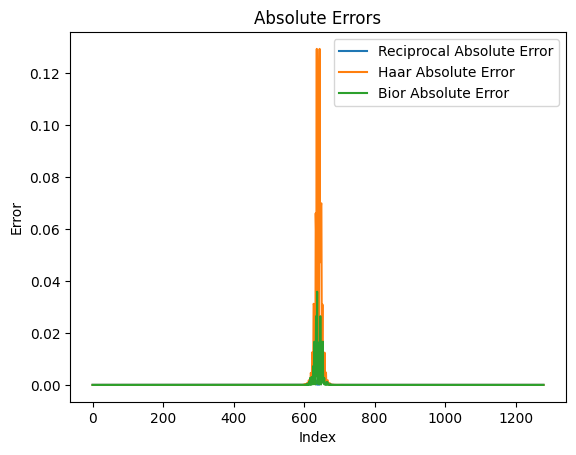

In [18]:
# 1 party protocol to visualize graphs

x = torch.arange(-64, 64, 0.1)
x_enc = curl.cryptensor(x)

curl.print("Tanh:")
print("  Exact :", x.tanh()[:print_terms])
with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.tanh()  # Private
    curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.tanh(), z_enc, plot_error=True, title='Reciprocal')
with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.tanh()  # Private
    curl.print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.tanh(), z_enc, plot_error=True, title='Haar')
with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.tanh()  # Private
    curl.print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.tanh(), z_enc, plot_error=True, title='Bior')

In [5]:
# multiparty script to check accuracy

import curl.mpc as mpc

@mpc.run_multiprocess(world_size=2)    
def test_tanh():
    x = torch.arange(-64, 64, 0.1)
    x_enc = curl.cryptensor(x)

    curl.print("Tanh:")
    print("  Exact :", x.tanh()[:print_terms])
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.tanh()  # Private
        curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.tanh(), z_enc, plot_error=True, title='Reciprocal')
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.tanh()  # Private
        curl.print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.tanh(), z_enc, plot_error=True, title='Haar')
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.tanh()  # Private
        curl.print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.tanh(), z_enc, plot_error=True, title='Bior')

test_tanh()

  Exact :Tanh: 
  Exact :tensor([-1.]) 
tensor([-1.])
  Approx: 1 iterations in 0.07154735800031631 sec.: tensor([-1.0000])
TAE: 1.066899e-01, MAE: 8.335148e-05, MRE: 8.589935e+08, MAX: 3.906250e-03, ARGMAX: 640
  Haar  : 1 iterations in 0.17638190599973314 sec.: tensor([-1.])
TAE: 1.329130e+00, MAE: 1.038383e-03, MRE: 1.370699e+10, MAX: 1.198049e-01, ARGMAX: 643
  Bior  : 1 iterations in 0.1966473969996514 sec.: tensor([-1.])
TAE: 2.007123e-01, MAE: 1.568065e-04, MRE: 9.395241e+07, MAX: 2.647275e-02, ARGMAX: 634


[None, None]

## Erf

Erf:
  Approx: 1 iterations in 0.08846723899978315 sec.: tensor([98524.9453])
TAE: 9.785526e+10, MAE: 7.644942e+07, MRE: 7.644942e+07, MAX: 2.728798e+08, ARGMAX: 1000
  Haar  : 1 iterations in 0.03265878000001976 sec.: tensor([-1.])
TAE: 1.279070e+00, MAE: 9.992733e-04, MRE: 1.370868e+10, MAX: 1.183466e-01, ARGMAX: 642
  Bior  : 1 iterations in 0.04274771099971986 sec.: tensor([-1.])
TAE: 3.774129e-03, MAE: 2.948538e-06, MRE: 2.973684e+06, MAX: 3.612041e-04, ARGMAX: 632


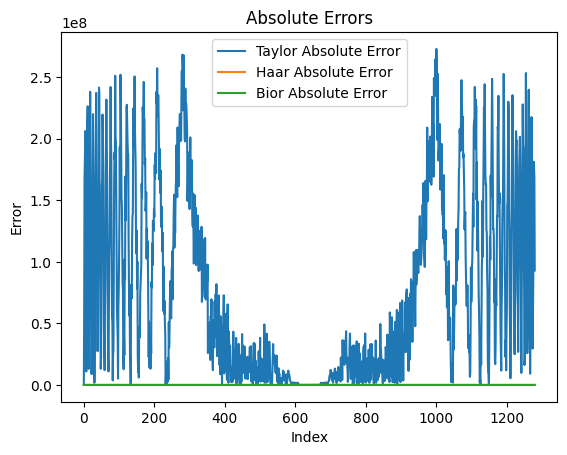

In [19]:
# 1 party protocol to visualize graphs

x = torch.arange(-64, 64, 0.1)
x_enc = curl.cryptensor(x)

curl.print("Erf:")
with cfg.temp_override({"functions.erf_method": 'Taylor'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.erf()  # Private
    curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.erf(), z_enc, plot_error=True, title='Taylor')
with cfg.temp_override({"functions.erf_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.erf()  # Private
    curl.print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.erf(), z_enc, plot_error=True, title='Haar')
with cfg.temp_override({"functions.erf_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.erf()  # Private
    curl.print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_errors(x.erf(), z_enc, plot_error=True, title='Bior')

In [6]:
# multiparty script to check accuracy

import curl.mpc as mpc

@mpc.run_multiprocess(world_size=2)    
def test_erf():
    x = torch.arange(-64, 64, 0.1)
    x_enc = curl.cryptensor(x)

    curl.print("Erf:")
    with cfg.temp_override({"functions.erf_method": 'Taylor'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.erf()  # Private
        curl.print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.erf(), z_enc, plot_error=True, title='Taylor')
    with cfg.temp_override({"functions.erf_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.erf()  # Private
        curl.print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.erf(), z_enc, plot_error=True, title='Haar')
    with cfg.temp_override({"functions.erf_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.erf()  # Private
        curl.print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_errors(x.erf(), z_enc, plot_error=True, title='Bior')

test_erf()

Erf:
  Approx: 1 iterations in 0.17511951100004808 sec.: tensor([98524.9453])
TAE: 1.272167e+11, MAE: 9.938807e+07, MRE: 9.938807e+07, MAX: 5.099843e+08, ARGMAX: 856
  Haar  : 1 iterations in 0.2036128750005446 sec.: tensor([-1.])
TAE: 1.275925e+00, MAE: 9.968163e-04, MRE: 1.370868e+10, MAX: 1.347369e-01, ARGMAX: 637
  Bior  : 1 iterations in 0.4137081990002116 sec.: tensor([-1.])
TAE: 4.188262e-03, MAE: 3.272080e-06, MRE: 2.973684e+06, MAX: 5.587935e-04, ARGMAX: 633


[None, None]

## Gelu


Gelu:
  Approx: 1 iterations in 0.13988946000017677 sec.
TAE: 3.681909e+11, MAE: 2.876492e+08, MRE: 7.556210e+12, MAX: 7.879783e+08, ARGMAX: 741
  Haar: 1 iterations in 0.031797056999948836 sec.
TAE: 8.803920e-01, MAE: 6.878062e-04, MRE: 4.392608e+10, MAX: 5.422974e-02, ARGMAX: 640
  Bior: 1 iterations in 0.03595614200003183 sec.
TAE: 2.786949e-01, MAE: 2.177304e-04, MRE: 1.606750e+09, MAX: 8.012421e-02, ARGMAX: 602


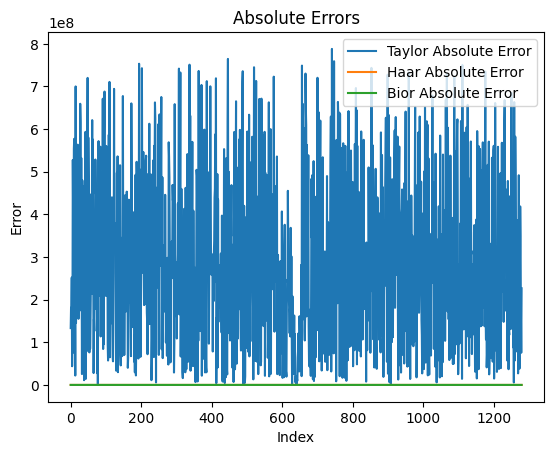

In [20]:
# 1 party protocol to visualize graphs

x = torch.arange(-64, 64, 0.1)
x_enc = curl.cryptensor(x)

gelu = x * (1 + (x / torch.sqrt(torch.tensor(2))).erf()) / 2
relu = x * (x > 0)

curl.print("\nGelu:")
with cfg.temp_override({"functions.gelu_method": 'erf', "functions.erf_method": 'Taylor'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Approx", timeit.default_timer(), start1)
    print_errors(gelu, z_enc, plot_error=True, title='Taylor')
with cfg.temp_override({"functions.gelu_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Haar", timeit.default_timer(), start1)
    print_errors(gelu, z_enc, plot_error=True, title='Haar')
with cfg.temp_override({"functions.gelu_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Bior", timeit.default_timer(), start1)
    print_errors(gelu, z_enc, plot_error=True, title='Bior')

In [7]:
# multiparty script to check accuracy

import curl.mpc as mpc

@mpc.run_multiprocess(world_size=2)    
def test_gelu():
    x = torch.arange(-64, 64, 0.1)
    x_enc = curl.cryptensor(x)

    gelu = x * (1 + (x / torch.sqrt(torch.tensor(2))).erf()) / 2
    relu = x * (x > 0)

    curl.print("\nGelu:")
    with cfg.temp_override({"functions.gelu_method": 'erf', "functions.erf_method": 'Taylor'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.gelu()  # Private
        print_app("Approx", timeit.default_timer(), start1)
        print_errors(gelu, z_enc, plot_error=True, title='Taylor')
    with cfg.temp_override({"functions.gelu_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.gelu()  # Private
        print_app("Haar", timeit.default_timer(), start1)
        print_errors(gelu, z_enc, plot_error=True, title='Haar')
    with cfg.temp_override({"functions.gelu_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.gelu()  # Private
        print_app("Bior", timeit.default_timer(), start1)
        print_errors(gelu, z_enc, plot_error=True, title='Bior')

test_gelu()


Gelu:
  Approx: 1 iterations in 0.14097546099947067 sec.
TAE: 3.571690e+11, MAE: 2.790383e+08, MRE: 1.025941e+13, MAX: 7.868937e+08, ARGMAX: 749
  Haar: 1 iterations in 0.07704525399913109 sec.
TAE: 9.273033e-01, MAE: 7.244557e-04, MRE: 4.392608e+10, MAX: 8.486657e-02, ARGMAX: 641
  Bior: 1 iterations in 0.07790821500020684 sec.
TAE: 3.546139e-01, MAE: 2.770421e-04, MRE: 1.606750e+09, MAX: 8.012421e-02, ARGMAX: 602


[None, None]

## Silu


Silu:
  Approx: 1 iterations in 0.09107045500013555 sec.
TAE: 2.174834e+03, MAE: 1.699089e+00, MRE: 2.722042e+24, MAX: 3.403320e+00, ARGMAX: 0
  Haar: 1 iterations in 0.037757876999876316 sec.
TAE: 4.173573e+00, MAE: 3.260604e-03, MRE: 7.500757e+10, MAX: 1.769956e-01, ARGMAX: 638
  Bior: 1 iterations in 0.043676743999640166 sec.
TAE: 1.360391e-01, MAE: 1.062805e-04, MRE: 5.368709e+08, MAX: 1.526999e-02, ARGMAX: 632


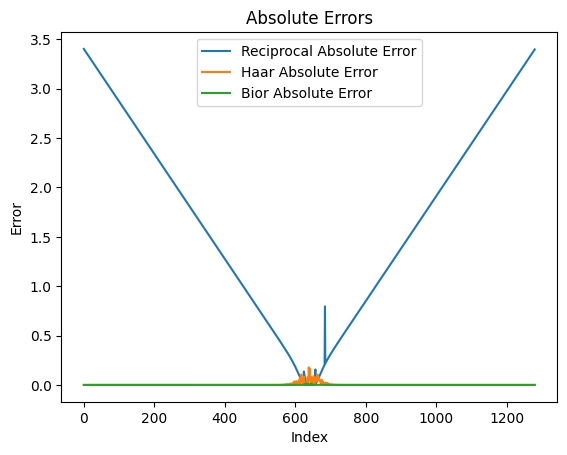

In [21]:
# 1 party protocol to visualize graphs

x = torch.arange(-64, 64, 0.1)
x_enc = curl.cryptensor(x)

silu = x * x.sigmoid()
relu = x * (x > 0)

curl.print("\nSilu:")
with cfg.temp_override({"functions.silu_method": 'sigmoid', "functions.sigmoid_tanh_method": 'reciprocal'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Private
    print_app("Approx", timeit.default_timer(), start1)
    print_errors(silu, z_enc, plot_error=True, title='Reciprocal')
with cfg.temp_override({"functions.silu_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Private
    print_app("Haar", timeit.default_timer(), start1)
    print_errors(silu, z_enc, plot_error=True, title='Haar')
with cfg.temp_override({"functions.silu_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Privat6
    print_app("Bior", timeit.default_timer(), start1)
    print_errors(silu, z_enc, plot_error=True, title='Bior')

In [8]:
# multiparty script to check accuracy

import curl.mpc as mpc

@mpc.run_multiprocess(world_size=2)    
def test_silu():
    x = torch.arange(-64, 64, 0.1)
    x_enc = curl.cryptensor(x)

    silu = x * x.sigmoid()
    relu = x * (x > 0)

    curl.print("\nSilu:")
    with cfg.temp_override({"functions.silu_method": 'sigmoid', "functions.sigmoid_tanh_method": 'reciprocal'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.silu()  # Private
        print_app("Approx", timeit.default_timer(), start1)
        print_errors(silu, z_enc, plot_error=True, title='Reciprocal')
    with cfg.temp_override({"functions.silu_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.silu()  # Private
        print_app("Haar", timeit.default_timer(), start1)
        print_errors(silu, z_enc, plot_error=True, title='Haar')
    with cfg.temp_override({"functions.silu_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.silu()  # Privat6
        print_app("Bior", timeit.default_timer(), start1)
        print_errors(silu, z_enc, plot_error=True, title='Bior')

test_silu()


Silu:
  Approx: 1 iterations in 0.41922994400010793 sec.
TAE: 2.176275e+03, MAE: 1.700215e+00, MRE: 2.722128e+24, MAX: 3.403320e+00, ARGMAX: 0
  Haar: 1 iterations in 0.11548756100000901 sec.
TAE: 3.819633e+00, MAE: 2.984088e-03, MRE: 7.500757e+10, MAX: 1.705475e-01, ARGMAX: 640
  Bior: 1 iterations in 0.4590341109997098 sec.
TAE: 1.865702e-01, MAE: 1.457580e-04, MRE: 5.368709e+08, MAX: 2.220154e-02, ARGMAX: 643


[None, None]